In [35]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, confusion_matrix

# Deep learning libraries
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import applications
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing import image

import cv2

import warnings
warnings.filterwarnings('ignore')

In [37]:
# Load datasets
labels = pd.read_csv("age classification.csv")
test_sample = pd.read_csv("test_sample.csv")

# Folder paths (use raw strings to handle backslashes correctly)
train_path = r"C:\MAIN PROJECT\Age classification\train"
test_path = r"C:\MAIN PROJECT\Age classification\test"

In [41]:
# Function to ensure correct file extension
def to_jpg(ID):
    # Remove any existing .jpg extension
    ID = str(ID).replace(".jpg", "")
    # Add the .jpg extension
    return ID + ".jpg"

# Apply the function to the training data
labels['ID'] = labels['ID'].apply(to_jpg)

# Apply the function to the test sample data
test_sample['ID'] = test_sample['ID'].apply(to_jpg)

In [43]:
print(labels.head())
print(test_sample.head())

      ID AGE CATEGORY
0  1.jpg        18-20
1  2.jpg        18-20
2  3.jpg        18-20
3  4.jpg        18-20
4  5.jpg        18-20
        ID AGE CATEGORY
0  126.jpg        18-20
1  127.jpg        18-20
2  128.jpg        18-20
3  129.jpg        18-20
4  130.jpg        18-20


In [45]:
# Image data generator with augmentation to prevent overfitting
gen = ImageDataGenerator(
    rescale=1./255.,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'  # Ensure this line ends with a closing parenthesis
)

In [47]:
# Training data generator
batch_size = 32
train_generator = gen.flow_from_dataframe(
    labels,  # dataframe
    directory=train_path,  # images data path / folder where images are stored
    x_col='ID',
    y_col='AGE CATEGORY',
    color_mode="rgb",
    target_size=(331, 331),  # image height , image width
    class_mode="categorical",
    batch_size=batch_size,  # Batch size
    shuffle=True,
    seed=42,
)

Found 125 validated image filenames belonging to 5 classes.


In [49]:
x, y = next(train_generator)
x.shape # input shape of one record is (331,331,3) , 32: is the batch size


(32, 331, 331, 3)

In [50]:
STEP_SIZE_TRAIN = train_generator.n // train_generator.batch_size

In [53]:
# Class names for plotting
a = train_generator.class_indices
class_names = list(a.keys())  # storing class/breed names in a list


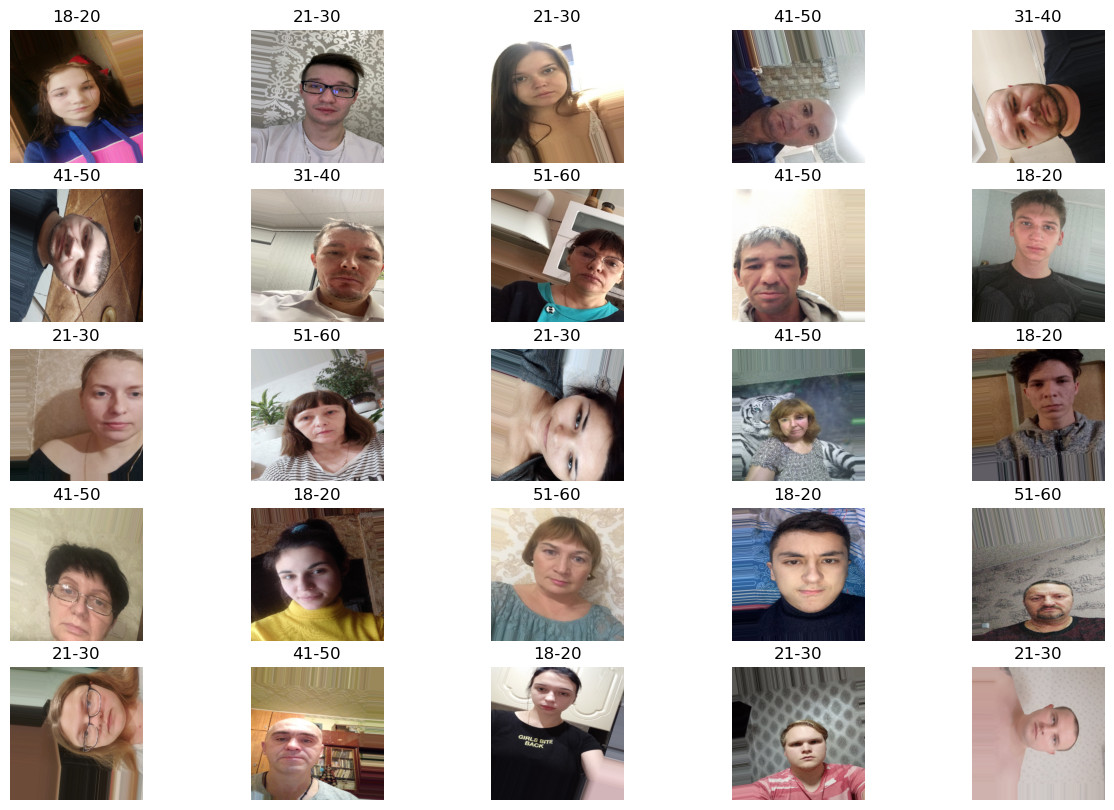

In [10]:
# Function to plot images
def plot_images(img, labels):
    plt.figure(figsize=[15, 10])
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.imshow(img[i])
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis('off')

plot_images(x, y)

In [55]:
# Load the InceptionResNetV2 architecture with ImageNet weights as the base model
base_model = tf.keras.applications.InceptionResNetV2(
    include_top=False,
    weights='imagenet',
    input_shape=(331, 331, 3)
)

# Unfreeze only a few top layers of the base model for fine-tuning
for layer in base_model.layers[-50:]:
    layer.trainable = True

In [ ]:
# Build the model with an explicit input layer
inputs = tf.keras.Input(shape=(331, 331, 3))
x = base_model(inputs, training=True)  # Allow base model layers to be trainable
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = tf.keras.layers.Dropout(0.6)(x)
x = tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = tf.keras.layers.Dropout(0.6)(x)
x = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
outputs = tf.keras.layers.Dense(5, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)

# Compile the model with a reduced learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Print a summary of the model
model.summary()

In [ ]:
# Use early stopping to prevent overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(
    patience=10, 
    min_delta=0.001, 
    restore_best_weights=True
)

# Fit model without validation data
history = model.fit(
    train_generator,
    steps_per_epoch=STEP_SIZE_TRAIN,
    epochs=50,
    callbacks=[early_stopping]  # Early stopping based on training performance
)

In [ ]:
# Assuming test_sample is already loaded and processed
# test_sample = pd.read_csv("test_sample.csv")  # Already done previously

# Set up the test data generator
test_gen = ImageDataGenerator(rescale=1./255.)  # Only rescaling, no augmentation

test_generator = test_gen.flow_from_dataframe(
    test_sample,  # Use the processed test_sample dataframe
    directory=test_path,  # Directory where the test images are stored
    x_col='ID',
    y_col='AGE CATEGORY',  # If you have labels; otherwise, set it to None
    target_size=(331, 331),  # Same size as used in training
    color_mode="rgb",
    class_mode="categorical",  # If labels are provided; use None if no labels
    batch_size=batch_size,
    shuffle=False  # Don't shuffle to maintain order of predictions
)

# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test accuracy: {test_acc}")
print(f"Test loss: {test_loss}")

# Generate predictions for the test data
predictions = model.predict(test_generator)

# Convert predictions to class labels
predicted_classes = np.argmax(predictions, axis=1)

# True labels
true_classes = test_generator.classes

# Class labels
class_labels = list(test_generator.class_indices.keys())

# Generate a classification report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

# Generate a confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
model.save('my_model.h5')  # You can change the file name and path as needed

print("Model saved successfully.")


In [63]:
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model('my_model.h5')

# Print a summary to ensure it's loaded correctly
model.summary()


ValueError: Unknown layer: 'CustomScaleLayer'. Please ensure you are using a `keras.utils.custom_object_scope` and that this object is included in the scope. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.